In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset,DataLoader
import torchvision 
from torchvision import transforms, models
from tqdm.notebook import tqdm
from PIL import Image
import seaborn as sns
from collections import OrderedDict
from glob import glob
import torch.nn.functional as F
from torch import nn, optim
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = {
    "train" : "/media/brats/DRIVE1/akansh/DeepXrays/Data/processed/Chest_XR_covid_resized_360/train/",
    "valid": "/media/brats/DRIVE1/akansh/DeepXrays/Data/processed/Chest_XR_covid_resized_360/validate/",
    "test" : "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/test/"
}

label_csv = {"train": '/media/brats/DRIVE1/akansh/DeepXrays/Data/processed/train_labels.csv',
            "valid": "/media/brats/DRIVE1/akansh/DeepXrays/Data/processed/validation_labels.csv",
            "test": "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/submission.csv"}

In [3]:
### Dataloader
class covid_dataset(Dataset):
    def __init__(self, image_loc, label_loc, transform, data_type = 'train'):
        filenames = []
        for root, dirs, files in os.walk(image_loc):
            for file in files:
                if file.endswith('.jpg') == True or file.endswith('.png') == True :
                    filenames.append(file)
#         print(len(filenames))
        if data_type == 'train' or data_type == 'valid':
            self.full_filenames = glob(image_loc+'*/*.*')
        else:
            self.full_filenames = glob(image_loc+'*.*')
#         print(len(self.full_filenames))
            
            
        label_df = pd.read_csv(label_loc)
        label_df.set_index("case", inplace = True)
        self.labels = [label_df.loc[filename].values[0] for filename in filenames]
        
        self.transform = transform
        
    def __len__(self):
        return len(self.full_filenames)
    
    def __getitem__(self,idx):
        image = Image.open(self.full_filenames[idx])
        image = image.convert('RGB')
        
        image = self.transform(image)
        return image, self.labels[idx]

In [4]:
data_transforms = {
    
    'train': transforms.Compose([
        transforms.CenterCrop((320,320)),
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.ColorJitter((0.85,1.05)),
        transforms.RandomRotation((-30,30)),
        transforms.ToTensor(),
        transforms.Normalize([0.5027,0.5027,0.5027],[0.2466, 0.2466, 0.2466])
        
    ]),
    
    'valid' : transforms.Compose([
        transforms.Resize((320,320)),
        transforms.ToTensor(),
        transforms.Normalize([0.5027,0.5027,0.5027],[0.2466, 0.2466, 0.2466])
    ])
    
    
}

In [5]:
valid_data = covid_dataset(image_loc = data_dir['valid'],
                          label_loc = label_csv['valid'],
                          transform = data_transforms['valid'],
                          data_type = 'valid')

train_data = covid_dataset(image_loc = data_dir['train'],
                          label_loc = label_csv['train'],
                          transform = data_transforms['train'],
                          data_type = 'train')

In [6]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(train_data.labels), train_data.labels) 
print(class_weights)

[0.91613101 0.83708572 1.4008893 ]


In [7]:
sample_weights = [0]*len(train_data)
for idx, (data,label) in tqdm(enumerate(train_data)):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight
from torch.utils.data import WeightedRandomSampler
sampler = WeightedRandomSampler(sample_weights, num_samples = len(sample_weights), replacement = True)

0it [00:00, ?it/s]

In [26]:
data_loader={
        'train': torch.utils.data.DataLoader(train_data, batch_size=64,shuffle=True),
        'valid': torch.utils.data.DataLoader(valid_data, batch_size=32,shuffle=False),
        }

### model

In [9]:
def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred, dim =1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [10]:
import torch.nn.functional as F
device = 'cuda'

In [11]:
from torch import nn
import torch.nn.functional as F
import timm # PyTorch Image Models

model = timm.create_model('tf_efficientnet_b3_ns',pretrained=True)

In [12]:
for param in model.parameters():
    param.requires_grad=True

In [13]:
model.classifier = nn.Sequential(
    nn.Linear(in_features=1536, out_features=625), #1792 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=3), 
)
model.to(device) 

EfficientNet(
  (conv_stem): Conv2dSame(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
     

In [25]:
# path2weights="/media/brats/DRIVE1/akansh/DeepXrays/Notebooks/Chest-XR-Grand_challenge/efficientNet-size320.pt"
# model.load_state_dict(torch.load(path2weights)['model_state_dict'])

<All keys matched successfully>

In [14]:
critertion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1,patience = 5, verbose = True)
epochs = 100
valid_loss_min = np.inf
best_acc = 0.0

In [27]:
train_loss_hist = []
valid_loss_hist = []
train_acc_hist = []
valid_acc_hist = []

for i in range(epochs):
    
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0 
    
    
    model.train()
    
    for images,labels in tqdm(data_loader['train']):
        images = images.to(device)
        labels = labels.to(device)
        
        ps = model(images)
        loss = critertion(ps,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc += accuracy(ps,labels)
        train_loss +=loss.item()
        
    avg_train_acc = train_acc / len(data_loader['train'])
    train_acc_hist.append(avg_train_acc)
    avg_train_loss = train_loss / len(data_loader['train'])
    train_loss_hist.append(avg_train_loss)
    
    model.eval()
    with torch.no_grad():
        for images,labels in tqdm(data_loader['valid']):
            images = images.to(device)
            labels = labels.to(device)
            
            ps = model(images)
            loss = critertion(ps,labels)
            
            valid_acc += accuracy(ps,labels)
            valid_loss += loss.item()
            
        avg_valid_acc = valid_acc / len(data_loader['valid'])
        valid_acc_hist.append(avg_valid_acc)
        avg_valid_loss = valid_loss / len(data_loader['valid'])
        valid_loss_hist.append(avg_valid_loss)
        
        schedular.step(avg_valid_loss)
        
        if avg_valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).Saving model ...'.format(valid_loss_min,avg_valid_loss))
            torch.save({
                'epoch' : i,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                'valid_loss_min' : avg_valid_loss
            },'efficientNet-size320.pt')
            
            valid_loss_min = avg_valid_loss
            
            
        if avg_valid_acc >= best_acc:
            print('Validation Accuracy increased ({:.6f} --> {:.6f}).Saving model ...'.format(best_acc,avg_valid_acc))
            torch.save({
                'epoch' : i,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                'valid_acc_max' : avg_valid_acc
            },'efficientNet_best_acc-size320.pt')
            
            best_acc = avg_valid_acc
            
            
        
            
    print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1,avg_train_loss,avg_train_acc))
    print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1,avg_valid_loss,avg_valid_acc))

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 1 Train Loss : 0.130054 Train Acc : 0.958759
Epoch : 1 Valid Loss : 0.193536 Valid Acc : 0.938079


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.125424 Train Acc : 0.958908
Epoch : 2 Valid Loss : 0.191785 Valid Acc : 0.937789


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.123836 Train Acc : 0.961630
Epoch : 3 Valid Loss : 0.189094 Valid Acc : 0.940683


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.127858 Train Acc : 0.958870
Epoch : 4 Valid Loss : 0.185491 Valid Acc : 0.940972


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.128054 Train Acc : 0.958127
Epoch : 5 Valid Loss : 0.194265 Valid Acc : 0.938368


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.124873 Train Acc : 0.960371
Epoch : 6 Valid Loss : 0.187117 Valid Acc : 0.941840


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.125764 Train Acc : 0.960055
Epoch : 7 Valid Loss : 0.192031 Valid Acc : 0.940104


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.129392 Train Acc : 0.958405
Epoch : 8 Valid Loss : 0.180157 Valid Acc : 0.942130


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.127433 Train Acc : 0.958241
Epoch : 9 Valid Loss : 0.193692 Valid Acc : 0.938947


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.123608 Train Acc : 0.960038
Epoch : 10 Valid Loss : 0.176947 Valid Acc : 0.943866


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 11 Train Loss : 0.130443 Train Acc : 0.958536
Epoch : 11 Valid Loss : 0.199207 Valid Acc : 0.934896


  0%|          | 0/281 [00:00<?, ?it/s]

KeyboardInterrupt: 

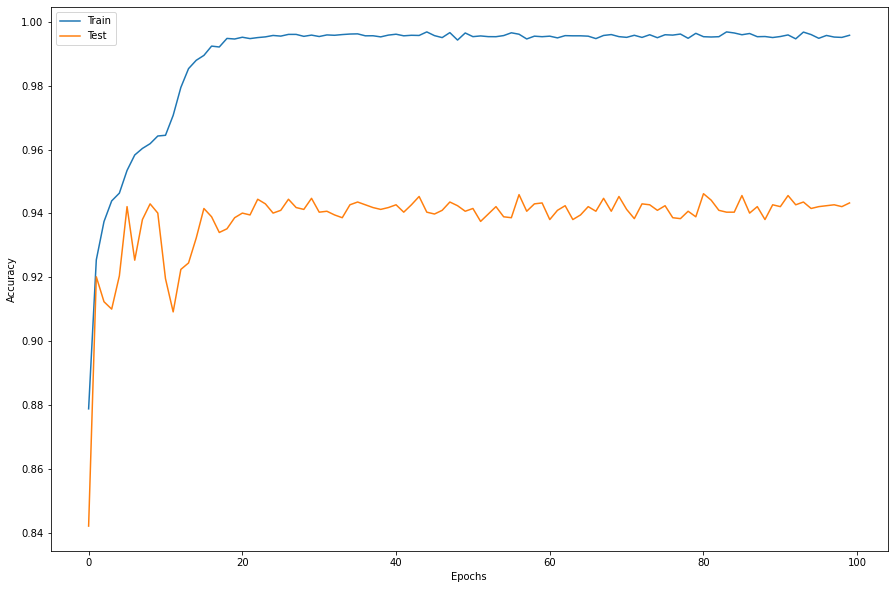

In [23]:
plt.figure(figsize=(15,10))
plt.plot(train_acc_hist, label = 'Train')
plt.plot(valid_acc_hist, label = 'Test')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig("/media/brats/DRIVE1/akansh/DeepXrays/Figures/Accuracy_eff_Net_320.jpg")

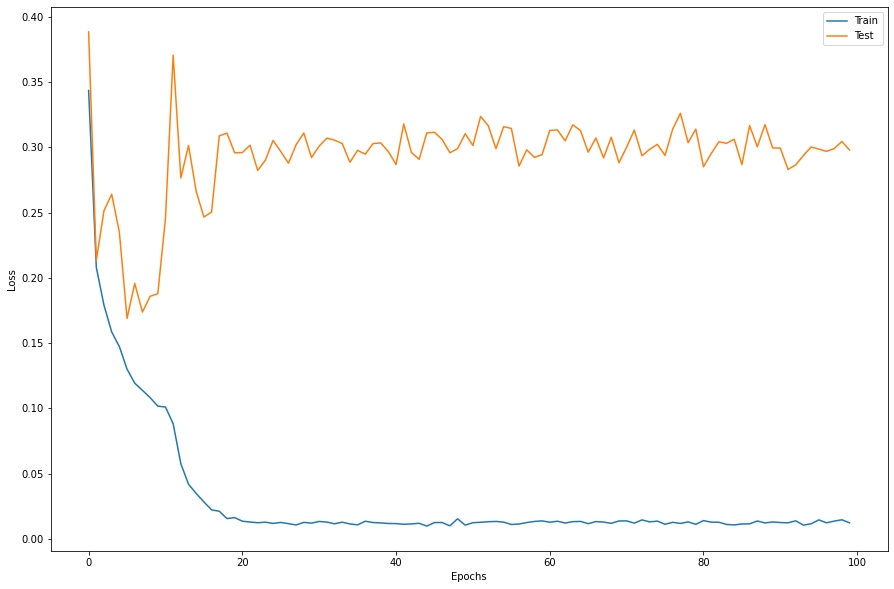

In [24]:
plt.figure(figsize=(15,10))
plt.plot(train_loss_hist, label = 'Train')
plt.plot(valid_loss_hist, label = 'Test')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("/media/brats/DRIVE1/akansh/DeepXrays/Figures/Loss_eff_Net_320.jpg")


In [34]:
!nvidia-smi

Wed Oct  6 23:16:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GT 710      Off  | 00000000:01:00.0 N/A |                  N/A |
| 40%   54C    P8    N/A /  N/A |    166MiB /  2000MiB |     N/A      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:02:00.0 Off |                  N/A |
| 30%   

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(train_loss_hist, label = 'Train')
plt.plot(valid_loss_hist, label = 'Test')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

### Inference

In [17]:
import pandas as pd
import seaborn as sns

def calc_confusion_matrix(model, loader, device, nb_classes):
    confusion_matrix = np.zeros((nb_classes, nb_classes))
    with torch.no_grad():
        for i, (inputs, classes) in tqdm(enumerate(loader)):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes, preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    return confusion_matrix.astype(int)


def plot_confusion_matrix(confusion_matrix, validloader, path_save):
    plt.figure(figsize=(15,10))

    class_names = ['covid', 'normal', 'pneumonia']
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    try:
        plt.savefig(path_save)
    except:
        pass

In [20]:
confusion_matrix = calc_confusion_matrix(model, data_loader['valid'], 'cuda', 3)

0it [00:00, ?it/s]

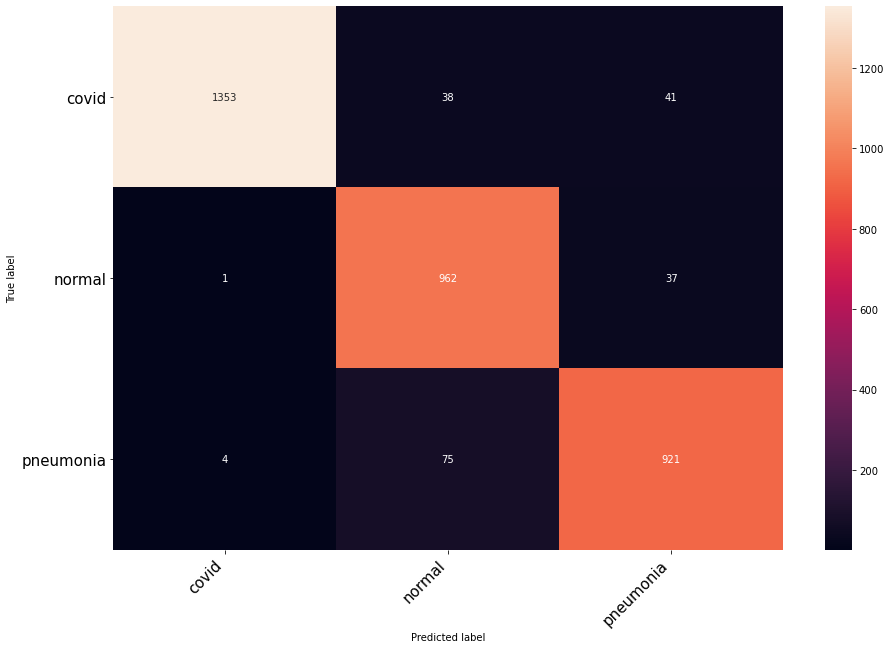

In [21]:
plot_confusion_matrix(confusion_matrix, data_loader['valid'], None)